# adc-to-opfb

This notebook tests the functionality of the core and is based on various PYNQ example notebooks.  

The overlay looks like 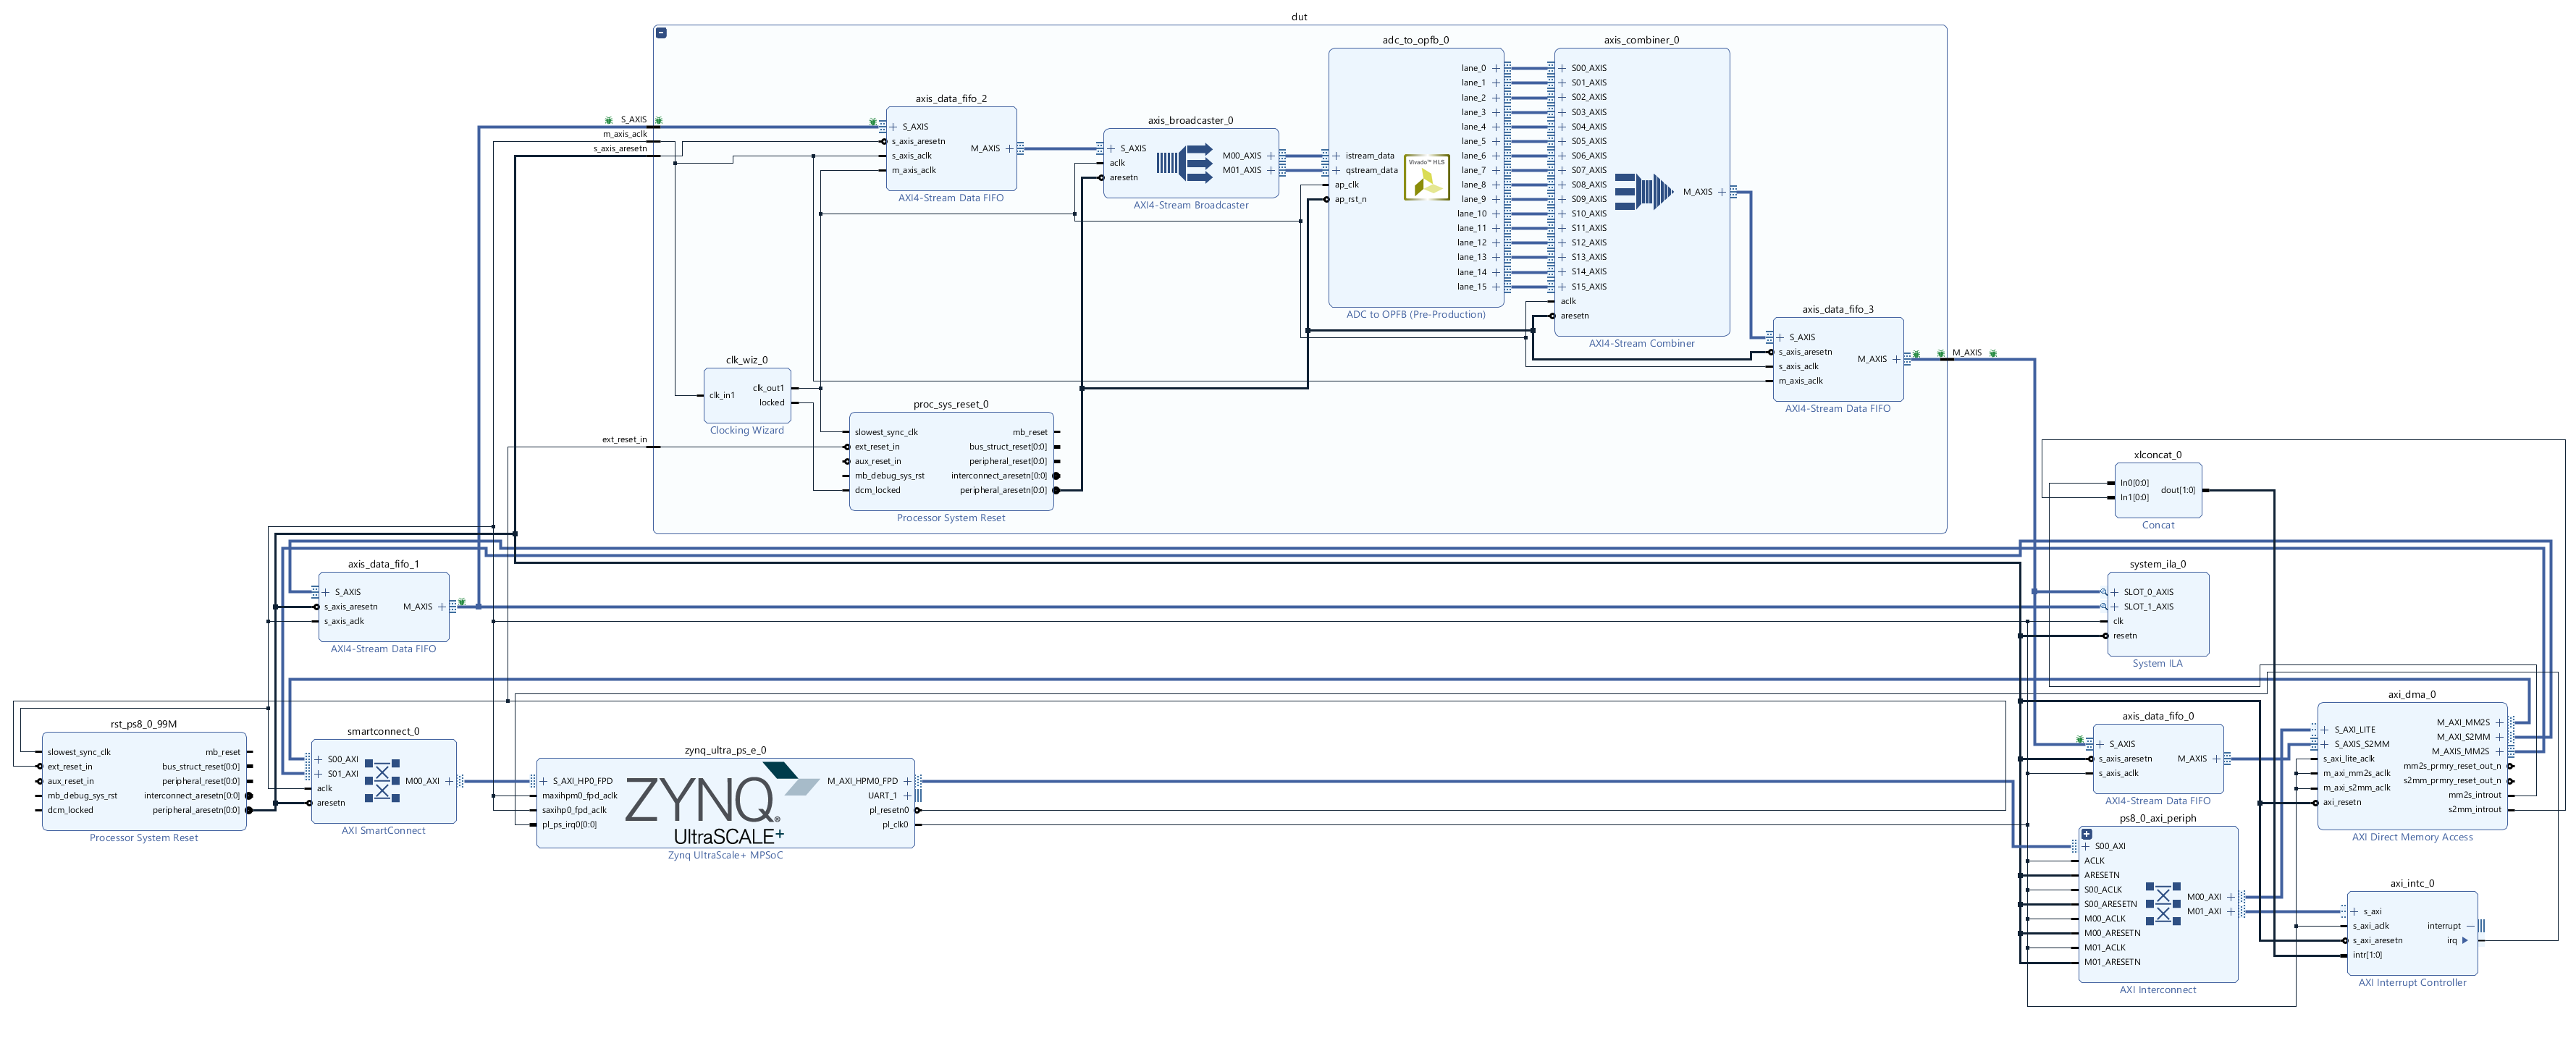

## 1. Instantiating an overlay
With the following overlay bundle present in the `overlays` folder, users can instantiate the overlay easily.

*  A bitstream file (\*.bit).
*  A tcl file (\*.tcl), or an hwh file (\*.hwh).
*  A python class (\*.py).

For example, an overlay called `base` can be loaded by:
```python
from pynq.overlays.base import BaseOverlay
overlay = BaseOverlay(SOME PATH)
```
Users can also use the absolute file path of the bitstream to instantiate the overlay.

In the following cell, we get the current bitstream loaded on PL, and try to download it multiple times. Then we can check the download timestamp for this overlay.

In [33]:
import numpy as np
from pynq import PL
from pynq import Overlay
from pynq import allocate
from pynq.xlnk import Xlnk
xlnk=Xlnk()
n_res = 2048
n_bin = 4096

def dma_status(dma):
    #dma.recvchannel.idle,dma.sendchannel.idle
    msg=("DMA:\n"
         " MM2s\n"
         f" Idle:{dma.sendchannel.idle}\n"
         f" MM2S_DMASR (status):{hex(dma.mmio.read(4))}\n"
         f" MM2S_SA (ptr) :{hex(dma.mmio.read(24))}\n"
         f" MM2S_LENGTH (len):{dma.mmio.read(40)}\n"
         " S2MM\n"
         f" Idle:{dma.recvchannel.idle}\n"
         f" S2MM_DMASR (status):{hex(dma.mmio.read(52))}\n"
         f" S2MM_DA (ptr) :{hex(dma.mmio.read(72))}\n"
         f" S2MM_LENGTH (len):{dma.mmio.read(88)}")
    print(msg)

In [34]:
ol = overlay = Overlay('/home/xilinx/overlayfiles/test_adc_to_opfb/test_adc2opfb.bit')
ol.download()
print(f"PL Bitfile: {PL.bitfile_name}\n  {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/overlayfiles/test_adc_to_opfb/test_adc2opfb.bit
  2020/2/18 19:56:4 +348882
Overlay timestamp: 2020/2/18 19:56:4 +348882  Loaded: True


## 3. Overlay Exploration


In [35]:
overlay.ip_dict.keys()

dict_keys(['axi_dma_0', 'axi_intc_0'])

In [36]:
overlay.ip_dict

{'axi_dma_0': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0x7f85ebde48>,
  'driver': pynq.lib.dma.DMA,
  'fullpath': 'axi_dma_0',
  'gpio': {},
  'interrupts': {'mm2s_introut': {'controller': 'axi_intc_0',
    'fullpath': 'axi_dma_0/mm2s_introut',
    'index': 0},
   's2mm_introut': {'controller': 'axi_intc_0',
    'fullpath': 'axi_dma_0/s2mm_introut',
    'index': 1}},
  'mem_id': 'S_AXI_LITE',
  'parameters': {'C_BASEADDR': '0xA0000000',
   'C_DLYTMR_RESOLUTION': '125',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_FAMILY': 'zynquplus',
   'C_HIGHADDR': '0xA000FFFF',
   'C_INCLUDE_MM2S': '1',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_DRE': '0',
   'C_INCLUDE_S2MM_SF': '1',
   'C_INCLUDE_SG': '0',
   'C_INCREASE_THROUGHPUT': '0',
   'C_MICRO_DMA': '0',
   'C_MM2S_BURST_SIZE': '256',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '128',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   

In [37]:
dma = ol.axi_dma_0

### Reading and writing DMA

Prepare memory for sending and recieving from the core.

In [38]:
input_buffer = allocate(shape=(n_res*2,), dtype=np.uint16)
output_buffer = allocate(shape=(n_res*2*2,), dtype=np.uint16)  # shape=(256,16,2) ix16qx16...x256

In [7]:
print(dma.mmio.base_addr,dma.mmio.length,dma.buffer_max_size)
for k,v in dma._registers.items():
    print(f"{k}: {v['address_offset']}  {v['access']}")

2684354560 65536 32768
MM2S_DMACR: 0  read-write
MM2S_DMASR: 4  read-write
MM2S_CURDESC: 8  read-write
MM2S_CURDESC_MSB: 12  read-write
MM2S_TAILDESC: 16  read-write
MM2S_TAILDESC_MSB: 20  read-write
MM2S_SA: 24  read-write
MM2S_SA_MSB: 28  read-write
MM2S_LENGTH: 40  read-write
SG_CTL: 44  read-write
S2MM_DMACR: 48  read-write
S2MM_DMASR: 52  read-write
S2MM_CURDESC: 56  read-write
S2MM_CURDESC_MSB: 60  read-write
S2MM_TAILDESC: 64  read-write
S2MM_TAILDESC_MSB: 68  read-write
S2MM_DA: 72  read-write
S2MM_DA_MSB: 76  read-write
S2MM_LENGTH: 88  read-write


### Generate and feed a stream

2048 16 bit numbers, note that operations like input_buffer[5:]=999 will kill the kernel (at least sometimes)!

Send two datasets worth to ensure we drive the tlast all the way through the core (latency is >1 for some versions) and check for bubbles & deal with the delay lines.

In [18]:
N_CYCLES=8  #must be even
N_GROUPS=256
N_LANES=16
N_ADC_OUT=8
packets = np.array([i*N_GROUPS*N_ADC_OUT+j*N_ADC_OUT+k 
         for i in range(N_CYCLES) 
         for j in range(N_GROUPS) 
         for k in range(N_ADC_OUT)], dtype=np.uint16)
packets=packets.reshape(N_CYCLES//2, N_ADC_OUT*N_GROUPS*2)
packets_out=np.zeros((N_CYCLES,N_GROUPS,N_LANES,2), dtype=np.uint16)

First cycle: 
  X16 X16 0 0 8 8 1 1 9 9 2 2 10 10 ... 7 7 15 15 X16 X16 16 16 24 24 ...23 23 31 31 X16 X16... ... ...2047 2047

Second Cycle:
  0 0 8 8 1 1 9 9 2 2 10 10 ... 7 7 15 15 2048 2048 2056 2056...2063 2063 16 16 24 24... 31 31 ... ... 4095 4095

In [47]:
for i in range(0,packets.shape[0]):
    print(f"Sending packet {i}")
    input_buffer[:]=packets[i]
    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
#     if i>0:
    print(f"Receiving packet {i}")
    dma.recvchannel.transfer(output_buffer)
    dma.recvchannel.wait()
    packets_out[i]=output_buffer.reshape((256,16,2))

Sending packet 0
Receiving packet 0
Sending packet 1
Receiving packet 1
Sending packet 2
Receiving packet 2
Sending packet 3
Receiving packet 3


### Look at the results

In [46]:
packets_out[3][0]

array([[4096, 4096],
       [4104, 4104],
       [4097, 4097],
       [4105, 4105],
       [4098, 4098],
       [4106, 4106],
       [4099, 4099],
       [4107, 4107],
       [4100, 4100],
       [4108, 4108],
       [4101, 4101],
       [4109, 4109],
       [4102, 4102],
       [4110, 4110],
       [4103, 4103],
       [4111, 4111]], dtype=uint16)